In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

c:\Users\Uttam Kumar\Learning\Time-series\codebase\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv('./data/test-1_cpu_usage_data.csv')

In [3]:
data.head()

,date,namespace,pods,cpu requested,cpu used,percentage of usage
0,07-09-2024,test-1,54,258.6,91.9,35.54
1,08-09-2024,test-1,177,606.0,245.7,40.54
2,09-09-2024,test-1,132,634.1,151.2,23.84
3,10-09-2024,test-1,108,482.3,144.2,29.90
4,11-09-2024,test-1,62,250.1,58.9,23.55


In [4]:
data['date'] = pd.to_datetime(data['date'], format='%d-%m-%Y')

In [7]:
last_date = data['date'].iloc[-30]

In [9]:
data = data[data.date <= last_date]

In [10]:
data.tail()

,date,namespace,pods,cpu requested,cpu used,percentage of usage
147,2025-02-01,test-1,116,407.8,146.8,36.00
148,2025-02-02,test-1,63,252.9,112.7,44.56
149,2025-02-03,test-1,192,944.3,201.2,21.31
150,2025-02-04,test-1,56,215.8,49.7,23.03
151,2025-02-05,test-1,147,499.0,105.4,21.12


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 181 non-null    datetime64[ns]
 1   namespace            181 non-null    object        
 2   pods                 181 non-null    int64         
 3   cpu requested        181 non-null    float64       
 4   cpu used             181 non-null    float64       
 5   percentage of usage  181 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 8.6+ KB


In [ ]:
train_data = data[data['date']<='']

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'RangeIndex'

In [5]:
df = pd.read_csv('./data/test-1_cpu_usage_data.csv') #,index_col=[0], parse_dates=[0]
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')
df.set_index(df['date'], inplace=True)

In [23]:
df.head()

,date,namespace,pods,cpu requested,cpu used,percentage of usage
date,,,,,,
2024-09-07,2024-09-07,test-1,54,258.6,91.9,35.54
2024-09-08,2024-09-08,test-1,177,606.0,245.7,40.54
2024-09-09,2024-09-09,test-1,132,634.1,151.2,23.84
2024-09-10,2024-09-10,test-1,108,482.3,144.2,29.90
2024-09-11,2024-09-11,test-1,62,250.1,58.9,23.55


In [6]:
df1 = df[['namespace', 'cpu used']]

In [25]:
df1.head()

,namespace,cpu used
date,,
2024-09-07,test-1,91.9
2024-09-08,test-1,245.7
2024-09-09,test-1,151.2
2024-09-10,test-1,144.2
2024-09-11,test-1,58.9


In [18]:
df1_ts = df1['cpu used'].resample('M').sum()

In [19]:
df1_ts.head()

date
2024-09-30    3516.6
2024-10-31    4319.2
2024-11-30    4264.4
2024-12-31    3872.7
2025-01-31    3937.1
Freq: ME, Name: cpu used, dtype: float64

<Axes: xlabel='date'>

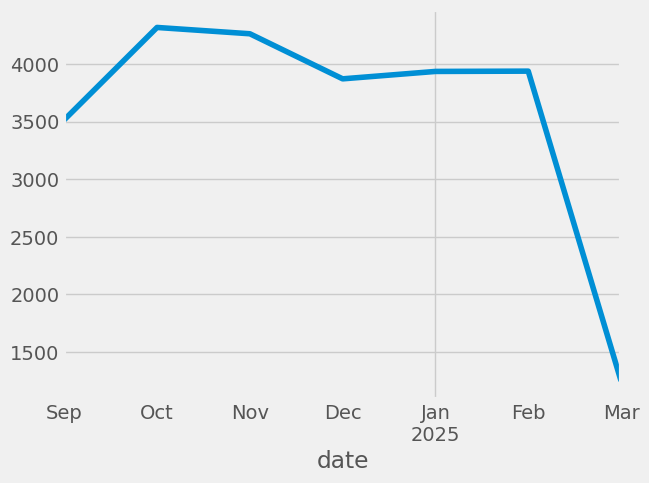

In [20]:
df1_ts.plot()

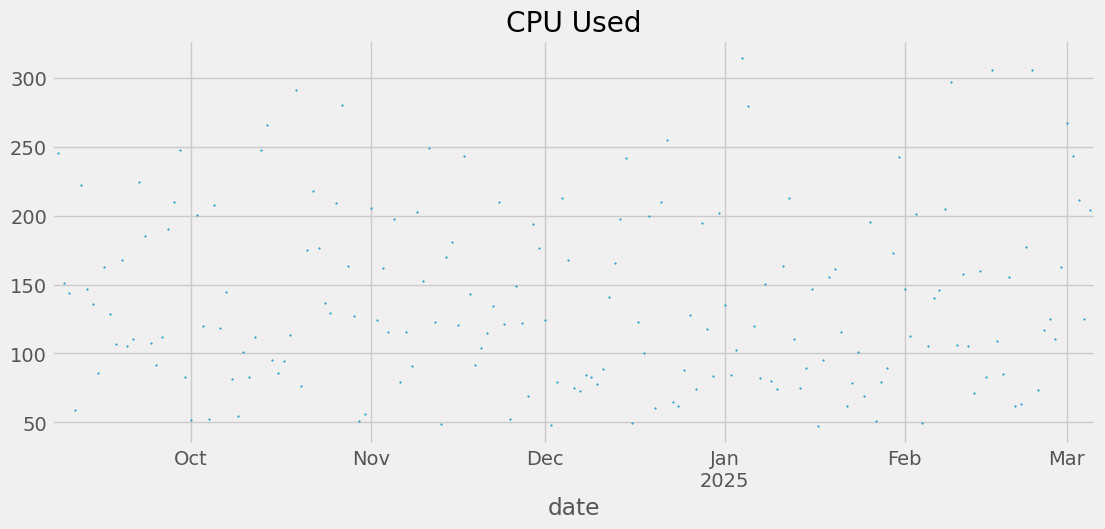

In [26]:
color_pal = sns.color_palette()
df1['cpu used'].plot(style='.',
          figsize=(12, 5),
          ms=1,
          color=color_pal[0],
          title='CPU Used')
plt.show()

## Time Series Features

In [30]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    #df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week #.weekofyear
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['dayofweek','quarter','month','year', #'hour',
           'dayofyear','dayofmonth','weekofyear','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(df1, label='cpu used')
features_and_target = pd.concat([X, y], axis=1)

In [31]:
features_and_target.head()

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,season,cpu used
date,,,,,,,,,,
2024-09-07,5,3,9,2024,251,7,36,Saturday,Summer,91.9
2024-09-08,6,3,9,2024,252,8,36,Sunday,Summer,245.7
2024-09-09,0,3,9,2024,253,9,37,Monday,Summer,151.2
2024-09-10,1,3,9,2024,254,10,37,Tuesday,Summer,144.2
2024-09-11,2,3,9,2024,255,11,37,Wednesday,Summer,58.9


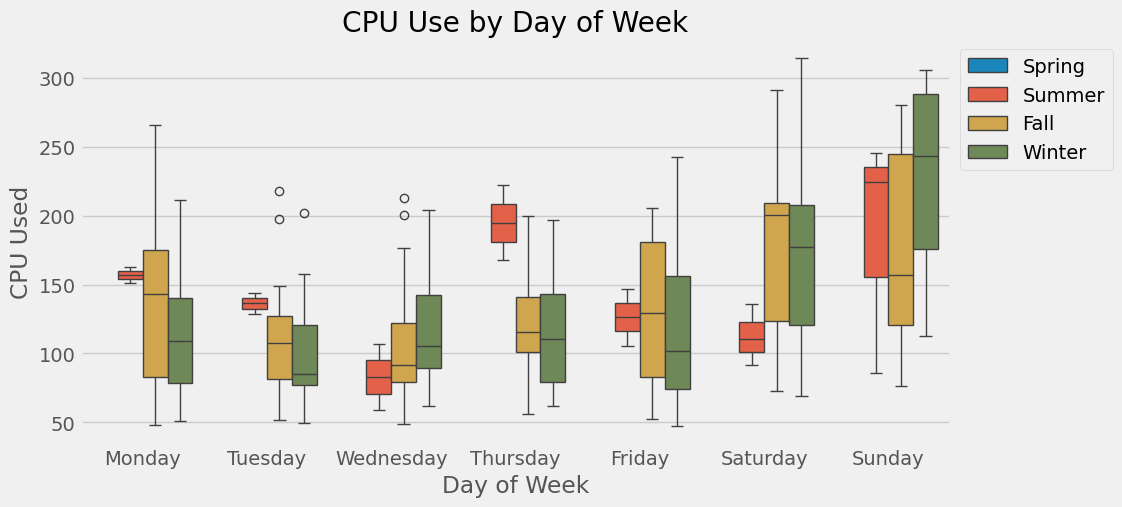

In [32]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='cpu used',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('CPU Use by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('CPU Used')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

## Train / Test Split

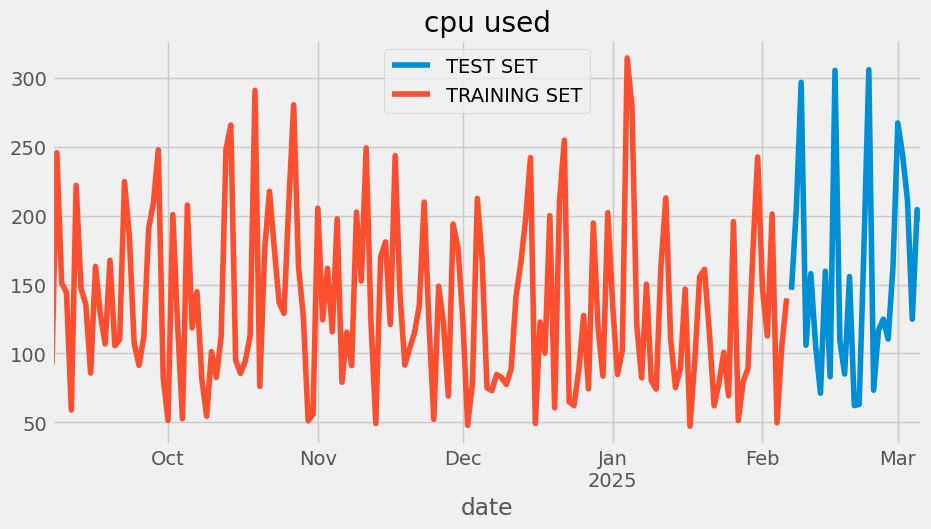

In [37]:
split_date = '2025-02-06'
df_train = df1.loc[df1.index <= split_date].copy()
df_test = df1.loc[df1.index > split_date].copy()

# Plot train and test so you can see where we have split
df_test \
    .rename(columns={'cpu used': 'TEST SET', 'namespace': 'TEST NS'}) \
    .join(df_train.rename(columns={'cpu used': 'TRAINING SET', 'namespace': 'TRAINING NS'}),
          how='outer') \
    .plot(figsize=(10, 5), title='cpu used', style='-', ms=1)
plt.show()

### Simple Prophet Model
Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model.

Datetime column named: ds \
target : y

In [39]:
# Format data for prophet model using ds and y
df_train_prophet = df_train.reset_index() \
    .rename(columns={'date':'ds',
                     'cpu used':'y'})

In [40]:
%%time
model = Prophet()
model.fit(df_train_prophet)

17:00:02 - cmdstanpy - INFO - Chain [1] start processing
17:00:02 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 109 ms
Wall time: 646 ms


In [41]:
# Predict on test set with model
df_test_prophet = df_test.reset_index() \
    .rename(columns={'date':'ds',
                     'cpu used':'y'})

df_test_fcst = model.predict(df_test_prophet)

In [42]:
df_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2025-02-07,125.806498,42.622378,185.171005,125.806498,125.806498,-12.677797,-12.677797,-12.677797,-12.677797,-12.677797,-12.677797,0.0,0.0,0.0,113.128701
1,2025-02-08,125.692137,92.105426,223.746184,125.692136,125.692137,31.585430,31.585430,31.585430,31.585430,31.585430,31.585430,0.0,0.0,0.0,157.277567
2,2025-02-09,125.577775,100.047792,241.369404,125.577775,125.577776,46.267917,46.267917,46.267917,46.267917,46.267917,46.267917,0.0,0.0,0.0,171.845692
3,2025-02-10,125.463414,52.220161,189.913019,125.463412,125.463416,-4.893069,-4.893069,-4.893069,-4.893069,-4.893069,-4.893069,0.0,0.0,0.0,120.570345
4,2025-02-11,125.349053,34.894893,169.472689,125.349050,125.349055,-23.237957,-23.237957,-23.237957,-23.237957,-23.237957,-23.237957,0.0,0.0,0.0,102.111096


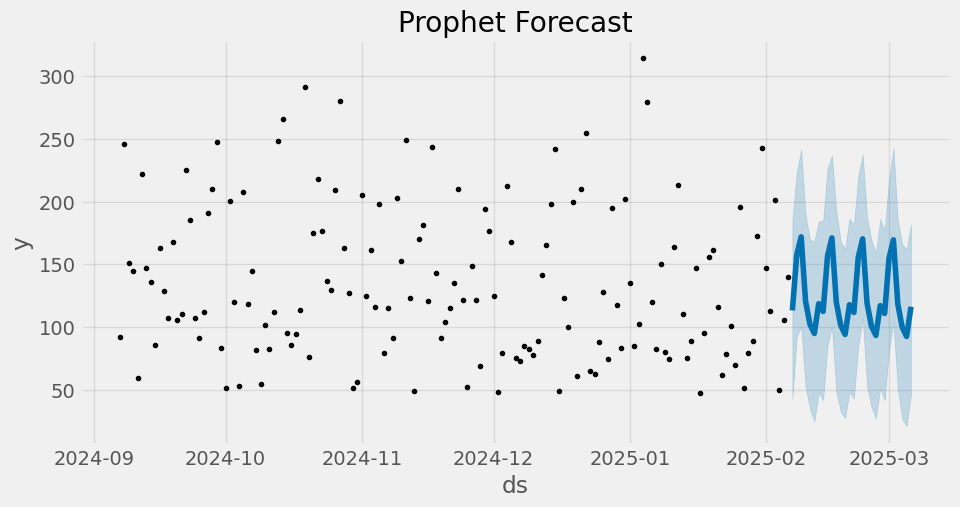

In [43]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(df_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

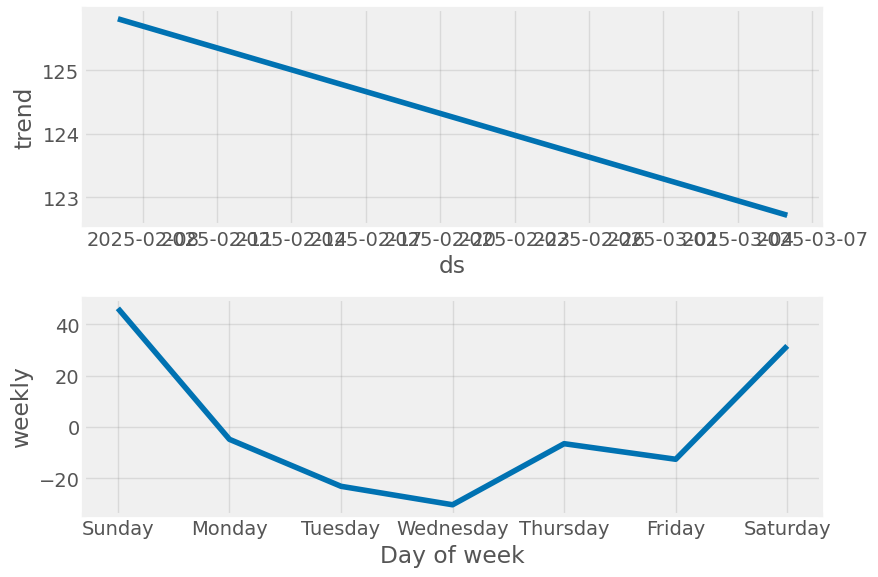

In [44]:
fig = model.plot_components(df_test_fcst)
plt.show()

## Compare Forecast to Actuals

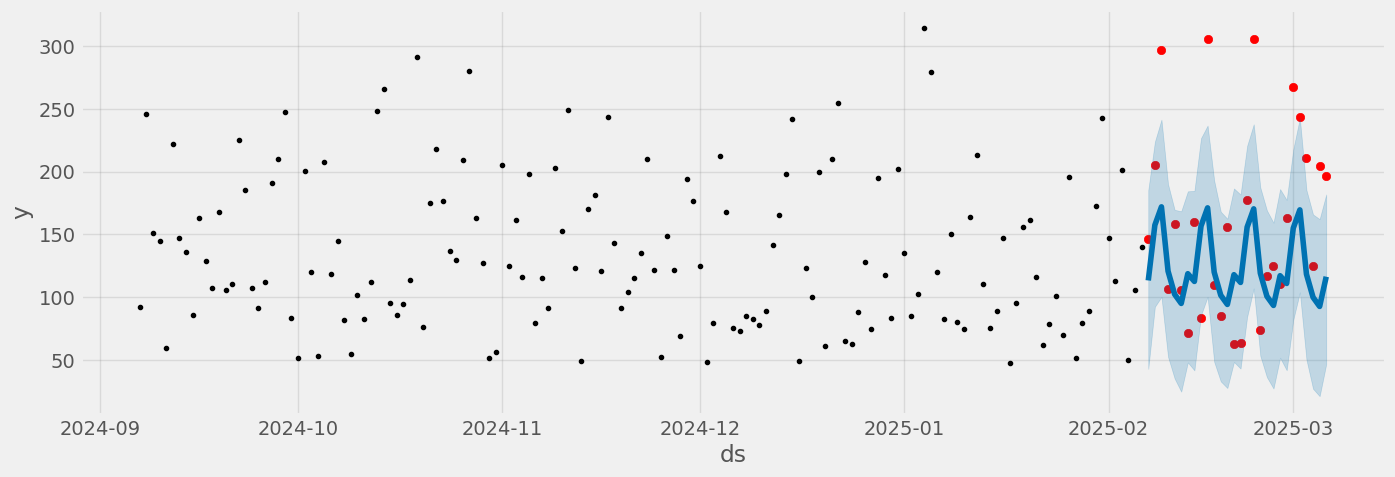

In [46]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(df_test.index, df_test['cpu used'], color='r')
fig = model.plot(df_test_fcst, ax=ax)

ConversionError: Failed to convert value(s) to axis units: '2024-09-07'

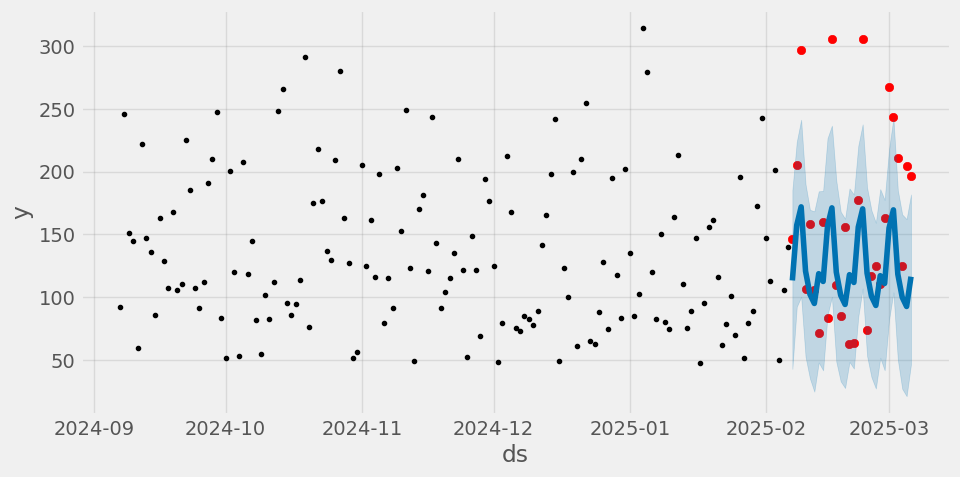

In [47]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(df_test.index, df_test['cpu used'], color='r')
fig = model.plot(df_test_fcst, ax=ax)
ax.set_xbound(lower='2024-09-07',
              upper='2025-03-05')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
ax.set_title('First Week of January Forecast vs Actuals')
plt.show()

## Evaluate the model with Error Metrics

In [ ]:
np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat']))

In [ ]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

In [ ]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

## Adding Holidays
Next we will see if adding holiday indicators will help the accuracy of the model. Prophet comes with a Holiday Effects parameter that can be provided to the model prior to training.

We will use the built in pandas USFederalHolidayCalendar to pull the list of holidays

In [9]:
st = pd.read_csv("./data/sales trend.csv", parse_dates=['login_date'], index_col=['login_date'])

## Resample the data
Aggregation of data \
Daily -> Monthly \
Monthly -> Annual

A => Year End \
M => Month End \
W => Weekly \
D => Daily \
MS => Month Start

In [23]:
ts = st['sales'].resample('D').sum()

In [24]:
ts.head()

login_date
2014-01-01    120
2014-01-02    122
2014-01-03    132
2014-01-04    136
2014-01-05    145
Freq: D, Name: sales, dtype: int64

## Stationary Check

In [21]:
import statsmodels.api as sm

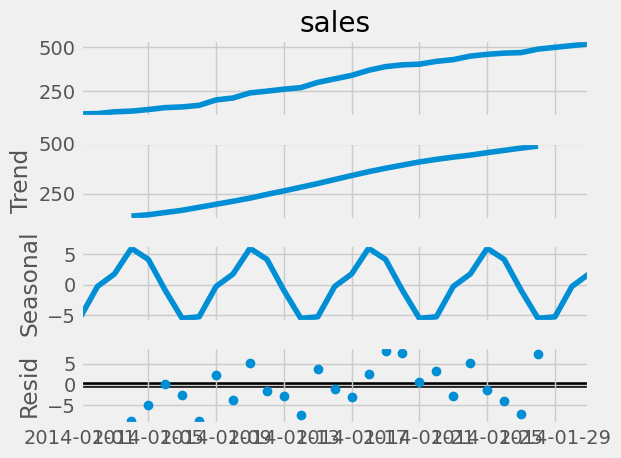

In [25]:
decomposition = sm.tsa.seasonal_decompose(ts, model='additive')
fig = decomposition.plot()
plt.show()

In [26]:
from statsmodels.tsa.stattools import adfuller

In [27]:
adftest = adfuller(ts)

In [28]:
print('p-value for adfuller test is ', adftest[1])

p-value for adfuller test is  0.9639660116664333


## Train Test Split

In [29]:
train = ts[:5]
test = ts[5:]

## ARIMA Model Building

3 Components
1. AR: Autoregression -> Regression with its past values ie. Dec sales dependent on Nov sales.
2. MA: Moving Average -> Yt depends on error of the previous lagged values.
3. Integrated: Differencing -> Difference the data to remove trend and seasonality to make it stationary.

p = ORDER OF AR; p=3 means Yt is dependent on past 3 periods. p from PACF plot.\
d = ORDER OF INTEGRATED: How many times we difference the data.\
q = ORDER OF MA; q from ACF plot.

### Hyperparameter of ARIMA Model - p,d,q

In [30]:
#p=5, d=0, q=4

## Build ARIMA Model

In [33]:
from statsmodels.tsa.arima.model import ARIMA

In [34]:
model = ARIMA(train, order=(5, 0, 4)).fit()

c:\Users\Uttam Kumar\Learning\Time-series\codebase\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Predict test dataset

In [35]:
import warnings
warnings.filterwarnings('ignore')

In [36]:
pred = model.predict(start=len(train), end=(len(ts)-1))

In [39]:
pred.head()

2014-01-06    145.198083
2014-01-07    148.424657
2014-01-08    142.109917
2014-01-09    139.487869
2014-01-10    129.247604
Freq: D, Name: predicted_mean, dtype: float64

In [40]:
test.head()

login_date
2014-01-06    156
2014-01-07    160
2014-01-08    169
2014-01-09    200
2014-01-10    211
Freq: D, Name: sales, dtype: int64

## Model Evaluation

In [37]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [38]:
error = np.sqrt(mean_squared_error(test, pred))
error

np.float64(251.15266615724659)

In [41]:
test.mean(), np.sqrt(test.var())

(np.float64(352.1923076923077), np.float64(118.92519303520824))

<Axes: xlabel='login_date'>

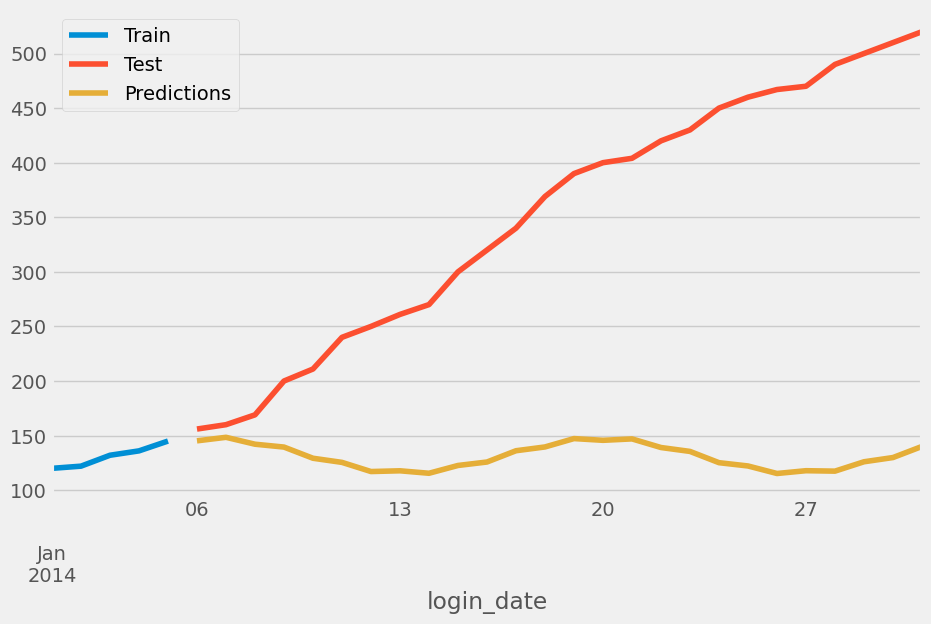

In [43]:
train.plot(legend=True, label='Train', figsize=(10, 6))
test.plot(legend=True, label='Test')
pred.plot(legend=True, label='Predictions')

## Predict Future data

In [44]:
final_model = ARIMA(ts, order=(5, 0, 4)).fit()

In [45]:
prediction = final_model.predict(len(ts), len(ts)+10)

In [47]:
prediction.head()

2014-02-01    523.117308
2014-02-02    521.517407
2014-02-03    524.769093
2014-02-04    523.028376
2014-02-05    517.135594
Freq: D, Name: predicted_mean, dtype: float64

<Axes: xlabel='login_date'>

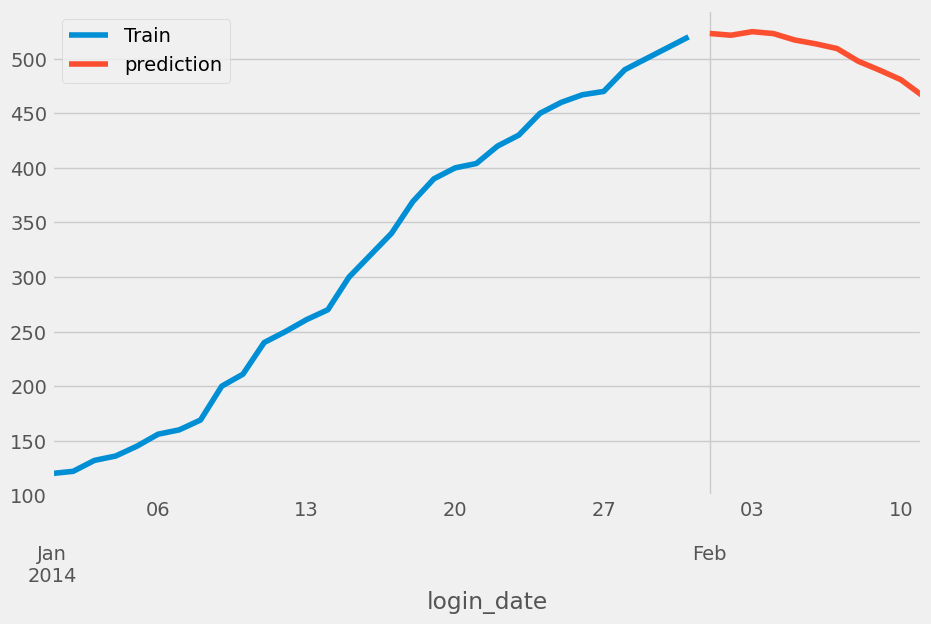

In [46]:
ts.plot(legend=True, label='Train', figsize=(10, 6))
prediction.plot(legend=True, label='prediction')

### How to get ARIMA Hyperparameters p, d, q
1. method ACF PACF Plots
2. auto_arima function
3. for loop

In [48]:
import itertools

In [49]:
p_values = range(0, 8)
d_values = range(0, 8)
q_values = range(0, 2)

In [50]:
pdq_combination = list(itertools.product(p_values, d_values, q_values))

In [51]:
len(pdq_combination)

128

In [52]:
rmse = []
order1 = []

In [53]:
for pdq in pdq_combination:
    try:
        model = ARIMA(train, order=pdq).fit()
        pred = model.predict(start=len(train), end=len(ts)-1)
        error = np.sqrt(mean_squared_error(test, pred))
        order1.append(pdq)
        rmse.append(error)
    except:
        continue
        

In [54]:
results = pd.DataFrame(index=order1, data=rmse, columns=['RMSE'])

In [55]:
results.head()

,RMSE
"(0, 0, 0)",250.050538
"(0, 0, 1)",248.844574
"(0, 1, 0)",237.755935
"(0, 1, 1)",235.383799
"(0, 2, 0)",99.383484


## ACF & PACF

In [56]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

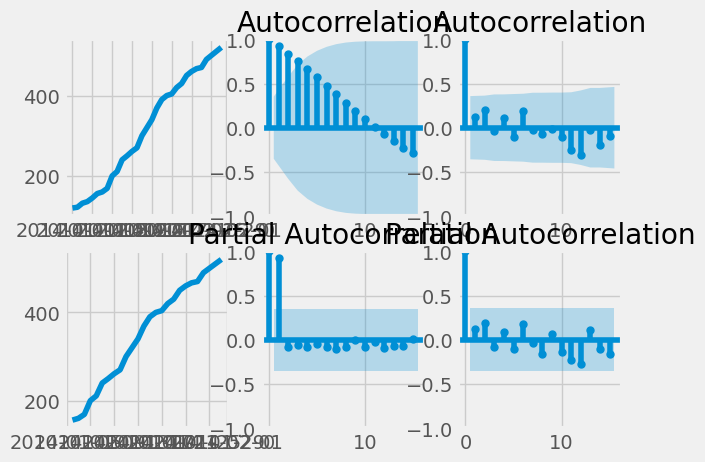

In [58]:
fig, axes = plt.subplots(2,3)
axes[0,0].plot(ts)
plot_acf(ts, ax=axes[0,1]) 
plot_acf(ts.diff().dropna(), ax=axes[0,2])
axes[1,0].plot(test)
plot_pacf(ts, ax=axes[1,1]) 
plot_pacf(ts.diff().dropna(), ax=axes[1,2])
plt.show()

### Auto ARIMA

In [60]:
#import pmdarima
#from pmdarima import auto_arima
#auto_arima(train, m=12, start_P=0, seasonal=True, d=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)

1. What is stationary ?
A stationaries time series is one whose properties do not depend on the time. Here, properties are Mean, Variance, Auto Correlation is constant over time.

2. How to check for seasonality ?
    * Visual Check: checking mean, variance, Auto correlation in the graph if it is changing over time.
    * Dickey-fuller Test: Using adfuller to identify p-value. low p-value(<=0.05) implies series is stationary.

3. How to make a series stationary ?

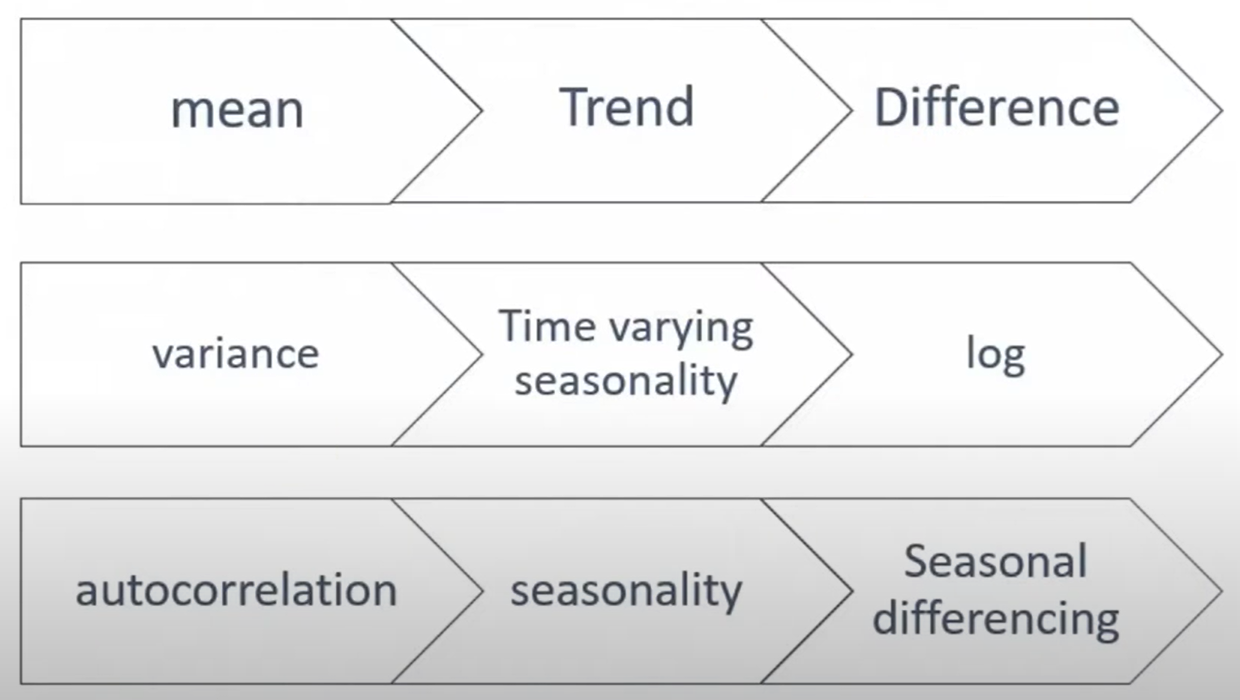



In [61]:
series1 = ts.diff()

In [62]:
series1.head()

login_date
2014-01-01     NaN
2014-01-02     2.0
2014-01-03    10.0
2014-01-04     4.0
2014-01-05     9.0
Freq: D, Name: sales, dtype: float64

<Axes: xlabel='login_date'>

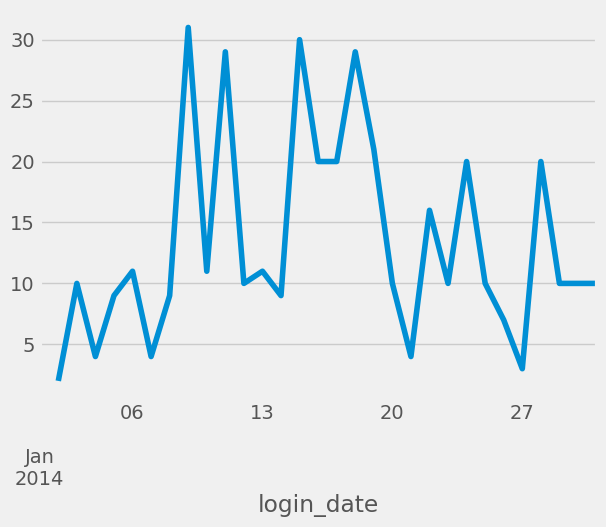

In [63]:
series1.plot()

In [64]:
adf1 = adfuller(series1.dropna())
print('p-value for adfuller test is ', adf1[1])

p-value for adfuller test is  6.890364088436888e-05


Trend -> take difference against previous days \
Seasonality -> difference of a period 12 instead of 1 \
Variance -> take log

In [3]:
m = Prophet()
m.add_country_holidays(country_name='US')
# m.fit(df)
m.train_holiday_names

In [4]:
m.train_holiday_names